<a href="https://colab.research.google.com/github/jumafernandez/data-science-II/blob/main/An%C3%A1lisis_Multivariado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Técnicas de Análisis Multivariado

En esta notebook se podrá encontrar una breve explicación de algunas de las principales técnicas clásicas de análisis estadístico multivariado:
- Regresión lineal múltiple,
- PCA (Análisis de Componentes Principales),
- LDA (Análisis del Discriminante Lineal).

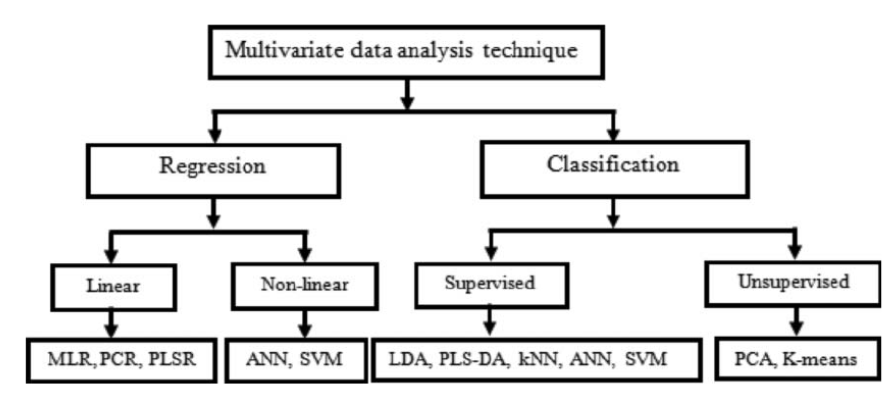

En el marco de esta notebook, si bien se asume el análisis cluster como una técnica de análisis multivariado clásico, no se incorpora dado que se propone más adelante como un tema con peso propio.

## Regresión lineal múltiple

La regresión lineal múltiple se utiliza para modelar la relación entre una variable dependiente y múltiples variables independientes.
Permite entender cómo varias variables influyen conjuntamente en la variable de interés.

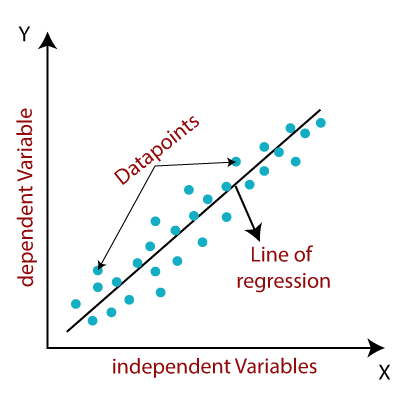

Se importan las librerías y se cargan los datos:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Cargar el dataset "Auto MPG" de seaborn
auto_mpg = sns.load_dataset('mpg')

# Mostrar las primeras filas del dataset
print(auto_mpg.head())


    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model_year origin                       name  
0          70    usa  chevrolet chevelle malibu  
1          70    usa          buick skylark 320  
2          70    usa         plymouth satellite  
3          70    usa              amc rebel sst  
4          70    usa                ford torino  


Se comienza con la preparación de los datos:
- Generación de dummies,
- Separación de variables independientes y variable dependiente,
- Casteo de tipos,
- etc.

In [ ]:
# Eliminar filas con valores nulos
auto_mpg = auto_mpg.dropna()

# Convertir la columna 'origin' en variables dummy
auto_mpg = pd.get_dummies(auto_mpg, columns=['origin'], drop_first=True)

auto_mpg.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model_year', 'name', 'origin_japan', 'origin_usa'],
      dtype='object')

In [ ]:
# Seleccionar las variables independientes y la variable dependiente
X = auto_mpg[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin_japan', 'origin_usa']]
y = auto_mpg['mpg']

# Asegurarse de que todas las columnas sean numéricas
X = X.apply(pd.to_numeric, errors='coerce')
y = y.apply(pd.to_numeric, errors='coerce')

X.dtypes

,0
cylinders,int64
displacement,float64
horsepower,float64
weight,int64
acceleration,float64
model_year,int64
origin_japan,bool
origin_usa,bool


Por alguna razón, `origin_japan` y `origin_usa` siguen siendo `bool`:


In [ ]:
# Convertir columnas booleanas a enteros (0 y 1)
X['origin_japan'] = X['origin_japan'].astype(int)
X['origin_usa'] = X['origin_usa'].astype(int)

X.dtypes

,0
cylinders,int64
displacement,float64
horsepower,float64
weight,int64
acceleration,float64
model_year,int64
origin_japan,int64
origin_usa,int64


Finalmente, se dividen los datos en train y test:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Hacemos un ajuste preliminar del modelo de __regresión lineal__ para la verificación de supuestos:

In [ ]:
import statsmodels.api as sm
import pandas as pd

# Check for non-numeric values in X_train
print(X_train.dtypes)  # Check data types of each column

# If any column is of type 'object', investigate further
# For example, check for unique values in those columns:
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        print(f"Unique values in column {col}: {X_train[col].unique()}")

# Convert problematic columns to numeric, handling errors appropriately
# For example, you can replace non-numeric values with NaN and then fill them:
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')  # Convert to numeric, replacing non-convertibles with NaN
        X_train[col] = X_train[col].fillna(X_train[col].mean())  # Fill NaN with the mean of the column

# Now try fitting the model again
modelo = sm.OLS(y_train, X_train).fit()

# Calcular residuos
residuos = modelo.resid

# Mostrar resumen del modelo
print(modelo.summary())

cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model_year        int64
origin_japan      int64
origin_usa        int64
dtype: object
                                 OLS Regression Results                                
Dep. Variable:                    mpg   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                              2083.
Date:                Mon, 26 Aug 2024   Prob (F-statistic):                   4.10e-261
Time:                        16:51:46   Log-Likelihood:                         -821.47
No. Observations:                 313   AIC:                                      1659.
Df Residuals:                     305   BIC:                                      1689.
Df Model:                           8                                                  
Co

Se avanza en la verificación de supuestos estadísticos básicos:

1. Linealidad

La relación entre las variables independientes y la variable dependiente debe ser lineal.

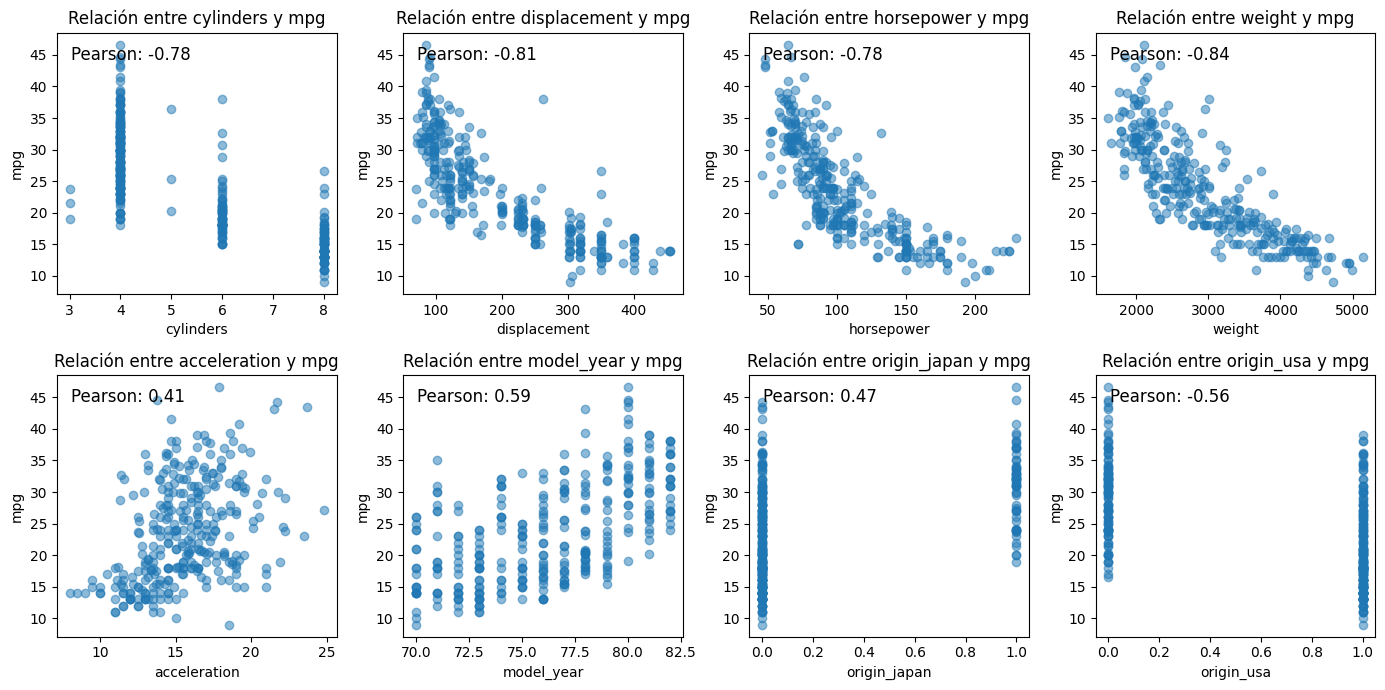

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Crear una figura y ejes con 2 filas y 4 columnas
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7))

# Recorrer las columnas y los ejes
for i, col in enumerate(X_train.columns):
    row = i // 4  # Índice de fila
    col_idx = i % 4  # Índice de columna

    # Graficar la relación entre la variable independiente y mpg
    axes[row, col_idx].scatter(X_train[col], y_train, alpha=0.5)
    axes[row, col_idx].set_title(f'Relación entre {col} y mpg')
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('mpg')

    # Calcular el coeficiente de correlación de Pearson
    pearson_corr, _ = pearsonr(X_train[col], y_train)

    # Añadir el valor del coeficiente de correlación al gráfico
    axes[row, col_idx].text(0.05, 0.95, f'Pearson: {pearson_corr:.2f}',
                            transform=axes[row, col_idx].transAxes,
                            fontsize=12, verticalalignment='top')

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()


2. Independencia de los errores (Prueba de Durbin-Watson):
Los residuos deben ser independientes.


La independencia de los errores significa que los residuos del modelo no deben mostrar patrones o correlaciones entre sí. La prueba de Durbin-Watson evalúa esta condición, midiendo si los residuos consecutivos están correlacionados. Un valor cercano a 2 indica independencia, mientras que valores cercanos a 0 o 4 sugieren autocorrelación.

In [ ]:
dw_statistic = sm.stats.durbin_watson(residuos)
print(f'Estadístico de Durbin-Watson: {dw_statistic}')

Estadístico de Durbin-Watson: 2.048518966490715


3. Homoscedasticidad
La varianza de los errores debe ser constante a lo largo de todas las observaciones.

Este supuesto puede verificarse graficando los residuos contra las predicciones.

Esto significa que la dispersión de los errores debe ser similar en todo el rango de valores predichos. Para verificar este supuesto, se grafica los residuos frente a las predicciones: si la varianza es constante, los puntos se distribuirán aleatoriamente sin formar patrones claros. Si observas un patrón, como un cono que se abre o cierra, podría indicar heteroscedasticidad, es decir, varianza no constante.

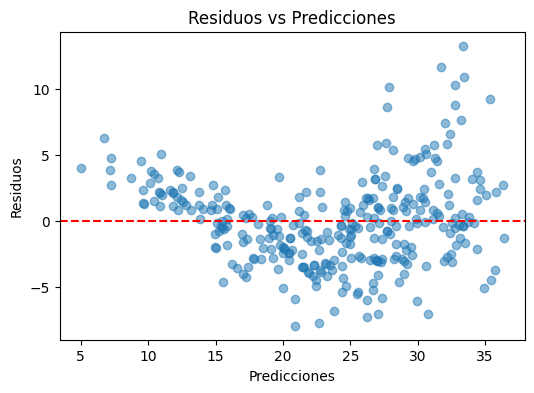

In [ ]:
# Graficar residuos vs predicciones
plt.figure(figsize=(6, 4))
plt.scatter(modelo.fittedvalues, modelo.resid, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuos vs Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.show()


4. Normalidad de los errores (Gráfico Q-Q y prueba de Shapiro-Wilk)

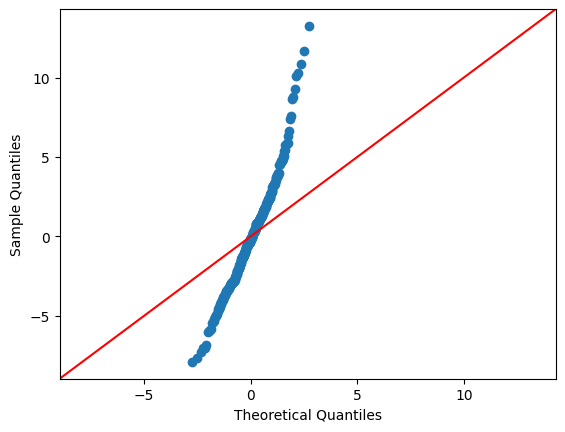

Estadístico de Shapiro-Wilk: 0.9735505994137387, p-valor: 1.6240732886212252e-05


In [ ]:
# Gráfico Q-Q
sm.qqplot(residuos, line='45')
plt.show()

# Prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuos)
print(f'Estadístico de Shapiro-Wilk: {shapiro_test[0]}, p-valor: {shapiro_test[1]}')


5. Ausencia de multicolinealidad

In [ ]:
# Calcular VIF para cada variable independiente
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data)

       Variable         VIF
0     cylinders  123.320670
1  displacement  102.369368
2    horsepower   65.784630
3        weight  136.601233
4  acceleration   68.943122
5    model_year  117.661715
6  origin_japan    2.480506
7    origin_usa    7.742143


Por último, una vez verificado el cumplimiento general de los supuestos, se avanza con el ajuste final del Modelo de Regresión Lineal con `sklearn`.

In [ ]:
# Ajustar el modelo final (si todo está en orden)
modelo_final = LinearRegression()
modelo_final.fit(X_train, y_train)

# Predicciones y evaluación del modelo
y_pred = modelo_final.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R^2): {r2}")


Error cuadrático medio (MSE): 10.602279011688328
Coeficiente de determinación (R^2): 0.7922774714022589


## PCA (Análisis de Componentes Principales)

El Análisis de Componentes Principales (PCA, por sus siglas en inglés) es una técnica estadística utilizada para reducir la dimensionalidad de los datos mientras se preserva la mayor cantidad de información posible. Esto se logra transformando los datos a un nuevo sistema de coordenadas donde las nuevas coordenadas (llamadas componentes principales) son ortogonales y están ordenadas según la cantidad de varianza que explican en los datos.

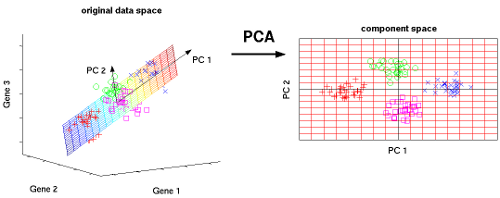

Se cargan en memoria las librerías y los datos:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

# Cargar un dataset de ejemplo
data = load_iris()
X = data.data
y = data.target
feature_names = data.feature_names

X[0:5,:]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

Se estandarizan los datos:

In [ ]:
# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[0:5,:]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

Se aplica PCA:

In [ ]:
# Aplicar PCA
pca = PCA()  # Reducir a 2 componentes principales
X_pca = pca.fit_transform(X_scaled)

Se verifica la varianza explicada por cada componente:

In [ ]:
# Mostrar la varianza explicada por cada componente
print("Varianza explicada por componente:", pca.explained_variance_ratio_)

print("Varianza explicada acumulada:", pca.explained_variance_ratio_.sum())

Varianza explicada por componente: [0.72962445 0.22850762 0.03668922 0.00517871]
Varianza explicada acumulada: 1.0


Se grafica la varianza acumulada:

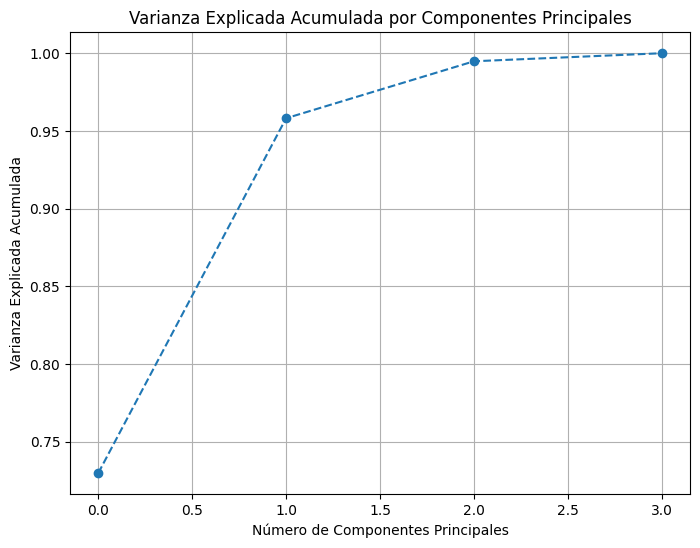

In [ ]:
# Varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Varianza explicada acumulada
cumulative_explained_variance = np.cumsum(explained_variance)

# Graficar varianza explicada acumulada
plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Varianza Explicada Acumulada por Componentes Principales')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.grid()
plt.show()


Tomamos las primeras dos componentes dado que explican más del 95% de la varianza total:

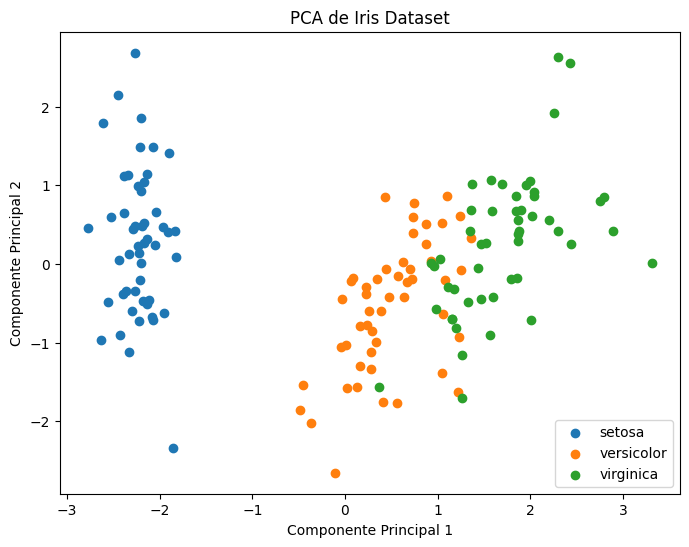

In [ ]:
# Crear un DataFrame para visualización
df_pca = pd.DataFrame(X_pca[:,0:2], columns=['PC1', 'PC2'])
df_pca['target'] = y

# Graficar los resultados
plt.figure(figsize=(8, 6))
for target in np.unique(y):
    plt.scatter(df_pca[df_pca['target'] == target]['PC1'],
                df_pca[df_pca['target'] == target]['PC2'],
                label=data.target_names[target])
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA de Iris Dataset')
plt.legend()
plt.show()


## LDA (Análisis del Discriminante Lineal)

LDA es una técnica de reducción de dimensionalidad, pero con un enfoque diferente al PCA. LDA se utiliza principalmente para la clasificación y tiene como objetivo maximizar la separación entre clases en los datos.

Al igual que PCA, LDA también realiza una proyección lineal de los datos, pero en lugar de buscar las direcciones de máxima varianza, busca las direcciones que maximizan la distancia entre las medias de las clases y minimizan la varianza dentro de cada clase.

<br />

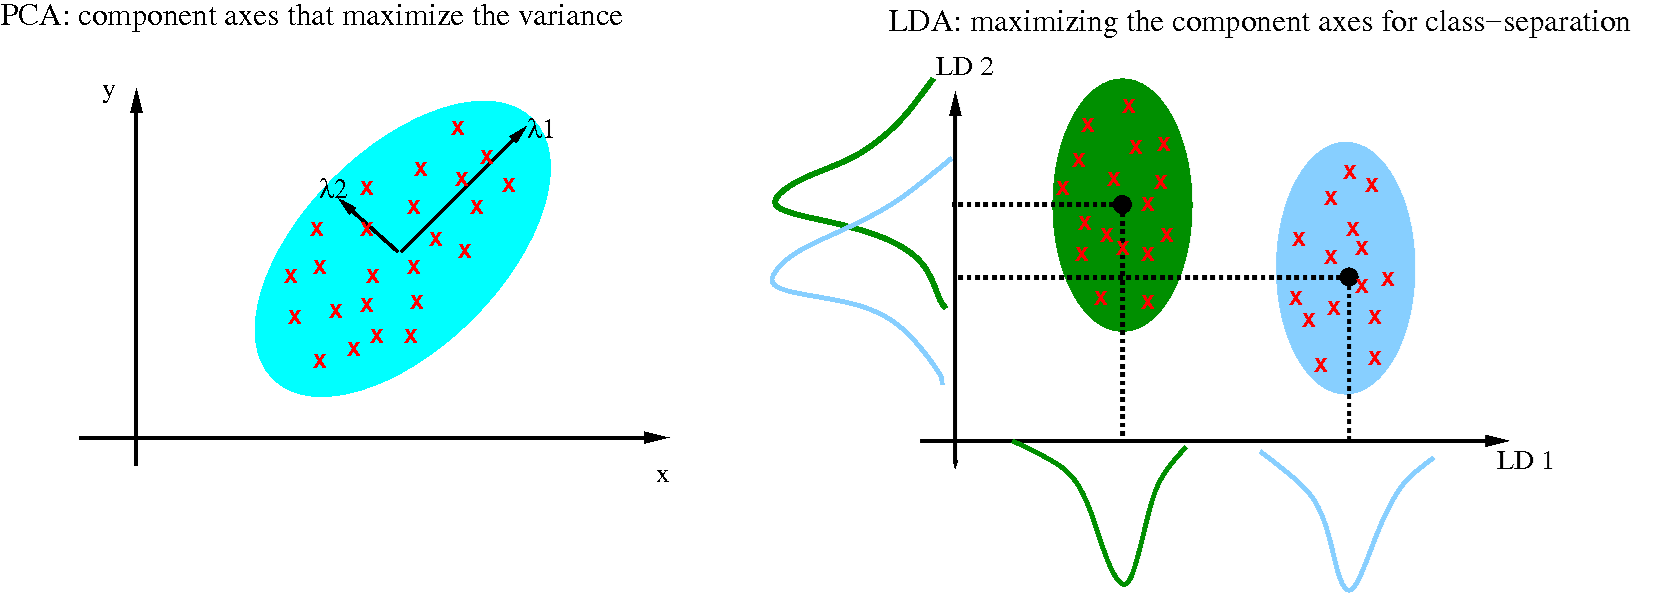

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

# Cargar datos
data = load_iris()
X = data.data
y = data.target

# Estandarizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar LDA
lda = LDA()
X_lda = lda.fit_transform(X_scaled, y)

# Varianza explicada por cada componente
explained_variance = lda.explained_variance_ratio_
print("Varianza explicada por cada componente:", explained_variance)
print("Varianza explicada acumulada:", explained_variance.sum())


Varianza explicada por cada componente: [0.9912126 0.0087874]
Varianza explicada acumulada: 1.0


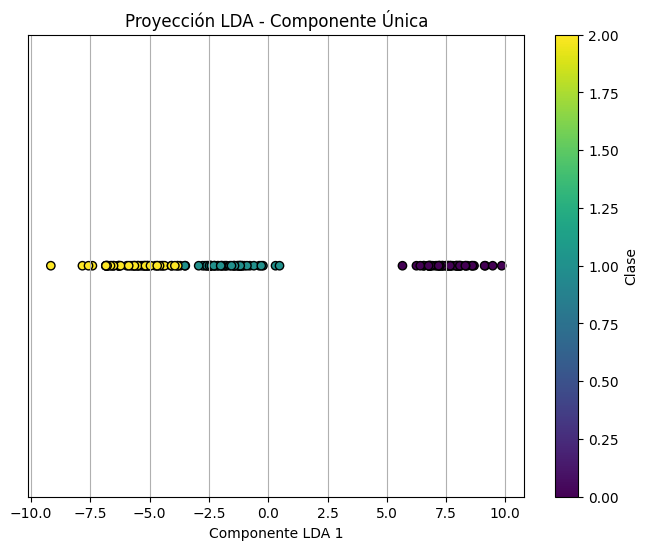

In [ ]:
import matplotlib.pyplot as plt

# Aplicar LDA con 1 componente
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_scaled, y)

# Crear gráfico de dispersión
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_lda, np.zeros_like(X_lda), c=y, cmap='viridis', edgecolor='k')
plt.yticks([])  # Eliminar las marcas del eje y porque solo hay una dimensión
plt.xlabel('Componente LDA 1')
plt.title('Proyección LDA - Componente Única')
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()


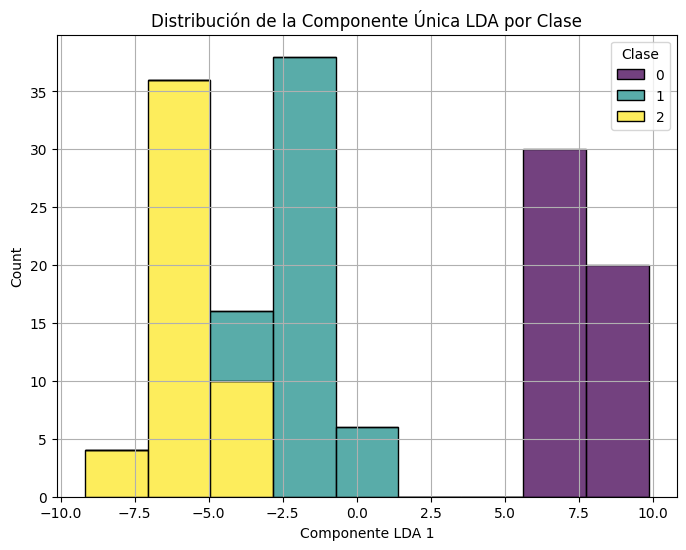

In [ ]:
import seaborn as sns

# Crear DataFrame para facilidad de uso con seaborn
import pandas as pd
df = pd.DataFrame({'LDA1': X_lda.flatten(), 'Clase': y})

# Crear histograma
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='LDA1', hue='Clase', multiple='stack', palette='viridis')
plt.xlabel('Componente LDA 1')
plt.title('Distribución de la Componente Única LDA por Clase')
plt.grid(True)
plt.show()


<ipython-input-30-5a0b400aa797>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Clase', y='LDA1', data=df, palette='viridis')


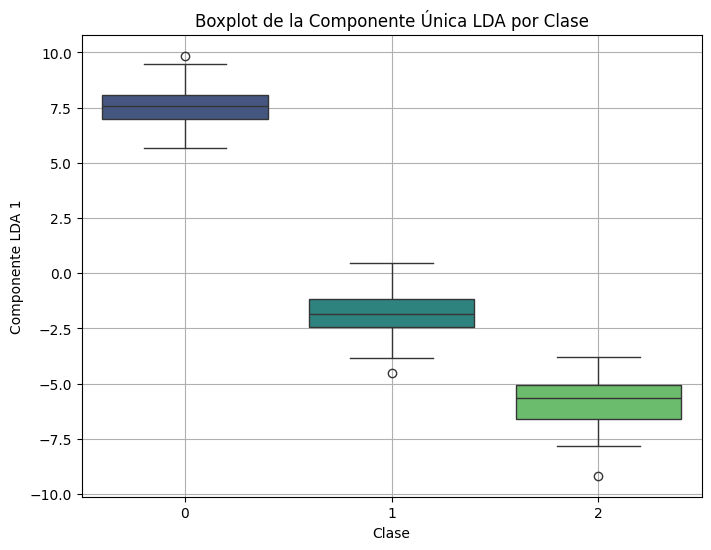

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Clase', y='LDA1', data=df, palette='viridis')
plt.xlabel('Clase')
plt.ylabel('Componente LDA 1')
plt.title('Boxplot de la Componente Única LDA por Clase')
plt.grid(True)
plt.show()
